In [2]:
import pandas as pd
import torch
import torch.nn as nn
import scipy.stats as sps
from scipy.interpolate import interp1d
from torch.utils.data import DataLoader
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from tqdm import tqdm
import seaborn as sns
import os
from typing import List
from matplotlib import cm 

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
print(device)

cuda:0


In [4]:
def usefulness(c, w, noice):
    # return 0.7
    return np.arctan(c - w + noice) / np.pi + 0.4


customer_distribution = sps.norm(0.6, 0.2)
w_distribution = sps.norm(0, 0.4)

epsilon = sps.norm(0, 0.05)


In [4]:
from models.u_predictor import NeuralNetwork, FeedbackDataset
from models.u_predictor import dynamic_system_iterate_u

In [5]:
start_c_size = 128
start_w_size = 128

user_info = pd.DataFrame({"F": customer_distribution.rvs(size=start_c_size)})  # генерим датасет для нулевой итерации
user_info["UserId"] = np.arange(start_c_size)

item_info = pd.DataFrame({"F": w_distribution.rvs(size=start_w_size)})
item_info["ItemId"] = np.arange(start_w_size)
feedback = []

for i, user_row in user_info.iterrows():
    for j, item_row in item_info.iterrows():
        deal = sps.bernoulli.rvs(usefulness(user_row["F"], item_row["F"], epsilon.rvs()))
        feedback.append((user_row["UserId"], item_row["ItemId"], deal))
feedback = pd.DataFrame(feedback, columns=['UserId', 'ItemId', 'Feedback'])
batch_size = 512
train_dataset = FeedbackDataset(feedback, user_info, item_info)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [6]:
loss_func = torch.nn.BCELoss()
model = NeuralNetwork(device, loss_func).to(device)
model.set_optimizer(torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999)))

model.fit_epoch(train_data_loader)

(0.0012654885649681091, 0.64300537109375)

100%|██████████| 250/250 [14:01<00:00,  3.36s/it]
/tmp/ipykernel_9443/3261873382.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


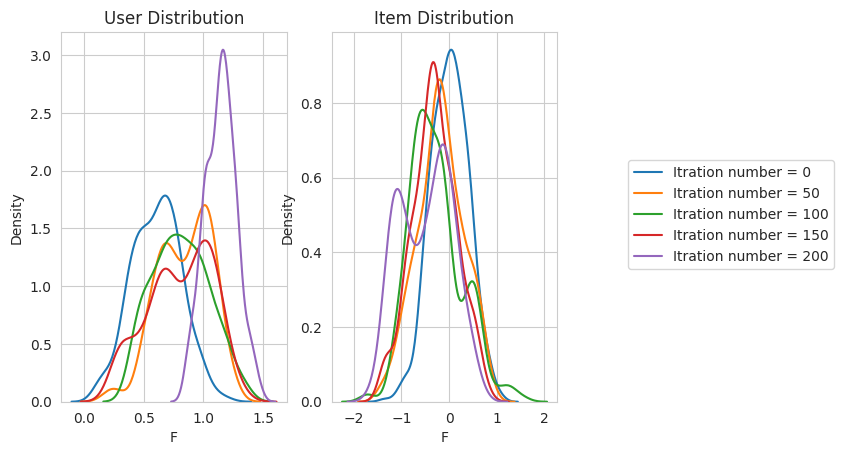

In [10]:
new_cust_distr, new_w_distr = customer_distribution, w_distribution
loss_history = []
residual_history = []
c_size = 256
w_size = 512
big_steps = 250
fig, axs = plt.subplots(ncols=2)
for i in tqdm(range(big_steps)):
    if i % 50 == 0:
        new_cust_distr, new_w_distr, loss, residual = dynamic_system_iterate_u(model, usefulness, epsilon.rvs()/(i + 1), new_cust_distr,
                                                                             new_w_distr,
                                                                             c_size=c_size,
                                                                             w_size=w_size, topn=8, delta=1e10,
                                                                             visualize_distributions=(i, axs))
    else:
        new_cust_distr, new_w_distr, loss, residual = dynamic_system_iterate_u(model, usefulness, epsilon.rvs()/(i + 1), new_cust_distr,
                                                                             new_w_distr,
                                                                             c_size=c_size,
                                                                             w_size=w_size, topn=8, delta=1e10)
    loss_history.append(loss)
    residual_history.append(residual)
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.show()

In [11]:
loss_history = np.array(loss_history).T

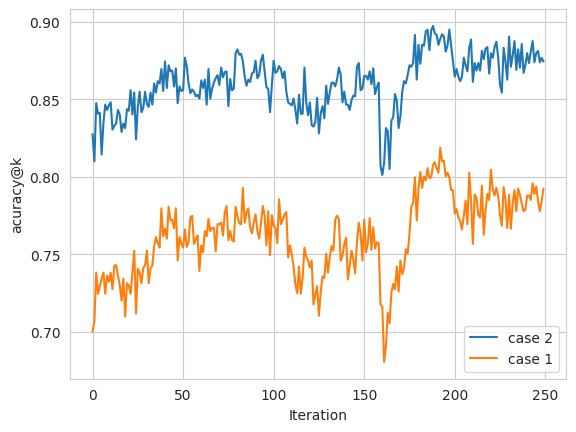

In [12]:

plt.plot(np.arange(big_steps), loss_history[0], label="case 2")
plt.plot(np.arange(big_steps), loss_history[1], label="case 1")

plt.xlabel("Iteration")
plt.ylabel("acuracy@k")
plt.legend()
plt.show()

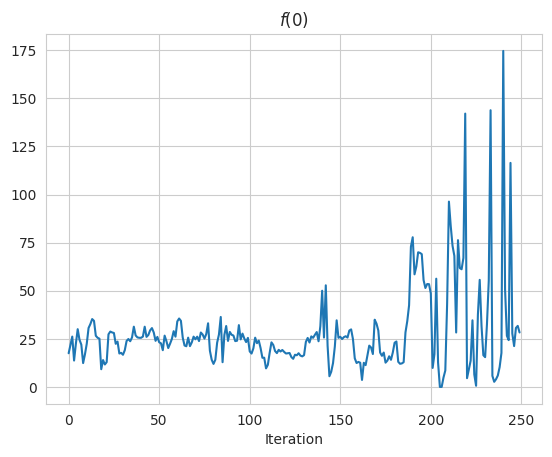

In [13]:
plt.plot(np.arange(big_steps), residual_history)
plt.xlabel("Iteration")
plt.title(r"$f(0)$")
# plt.title(r"$\frac{real \  feedback - predicted \ feedback} {num \ of \ predictions}$")
plt.show()

In [70]:
class Oracle:
    def recommend_topN(self, user_info, items_to_recommend, topn=10):
        n = min(topn, items_to_recommend.shape[0])
        res = np.array([usefulness(user_info["F"], items_to_recommend["F"].to_numpy(),
                                   epsilon.rvs(items_to_recommend.shape[0]))] * n)
        ids = np.argpartition(res, n - 1)
        return pd.DataFrame({"ItemId": ids[:n], "Rating": res[ids][:n]})

In [93]:
model = Oracle()

In [5]:
from models.CMF_Predictor import CMFRecommender, dynamic_system_iterate_CMF

start_c_size = 128
start_w_size = 128

user_info = pd.DataFrame({"F": customer_distribution.rvs(size=start_c_size)})  # генерим датасет для нулевой итерации
user_info["UserId"] = np.arange(start_c_size)

item_info = pd.DataFrame({"F": w_distribution.rvs(size=start_w_size)})
item_info["ItemId"] = np.arange(start_w_size)
feedback = []

for i, user_row in user_info.iterrows():
    for j, item_row in item_info.iterrows():
        deal = sps.bernoulli.rvs(usefulness(user_row["F"], item_row["F"], epsilon.rvs()))
        feedback.append((user_row["UserId"], item_row["ItemId"], deal))


In [6]:
# feedback = pd.DataFrame(feedback, columns=['UserId', 'ItemId', 'Feedback'])

model = CMFRecommender(capacity=1000000, num_of_factors=300)
model.fit(feedback, user_info, item_info)

100%|██████████| 101/101 [30:54<00:00, 18.36s/it]
/tmp/ipykernel_30338/4167953104.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


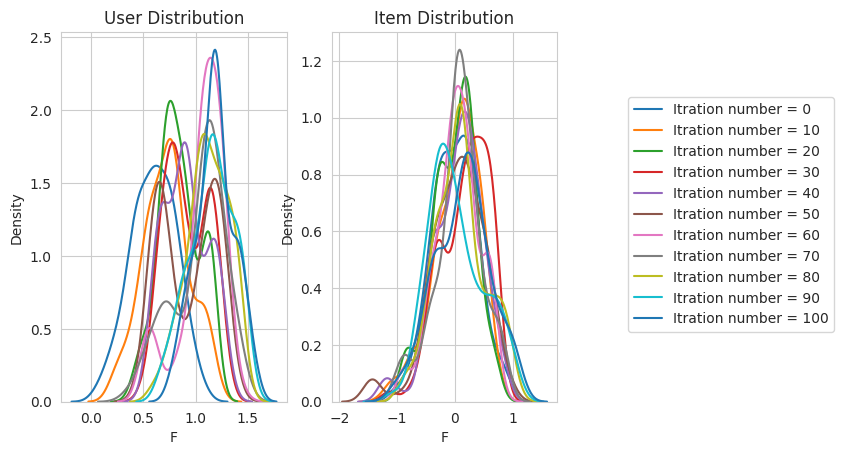

In [7]:
new_cust_distr, new_w_distr = customer_distribution, w_distribution
loss_history = []
residual_history = []
c_size = 128
w_size = 256
big_steps = 101
fig, axs = plt.subplots(ncols=2)
for i in tqdm(range(big_steps)):
    if i % 10 == 0:
        new_cust_distr, new_w_distr, loss, residual = dynamic_system_iterate_CMF(model, usefulness,
                                                                               epsilon.rvs() / (i + 1), new_cust_distr,
                                                                               new_w_distr,
                                                                               c_size=c_size,
                                                                               w_size=w_size, topn=8,
                                                                               delta=1e10,
                                                                               visualize_distributions=(i, axs))
    else:
        new_cust_distr, new_w_distr, loss, residual = dynamic_system_iterate_CMF(model, usefulness,
                                                                               epsilon.rvs() / (i + 1), new_cust_distr,
                                                                               new_w_distr,
                                                                               c_size=c_size,
                                                                               w_size=w_size, topn=8, delta=1e10)
    loss_history.append(loss)
    residual_history.append(residual)
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.show()

In [8]:
loss_history = np.array(loss_history).T

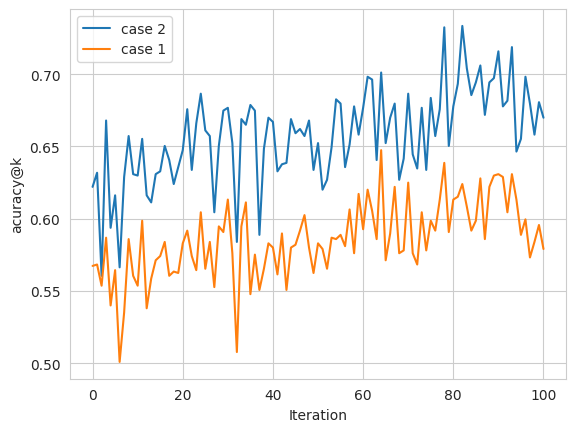

In [9]:
plt.plot(np.arange(big_steps), loss_history[0], label="case 2")
plt.plot(np.arange(big_steps), loss_history[1], label="case 1")

plt.xlabel("Iteration")
plt.ylabel("acuracy@k")
plt.legend()
plt.show()


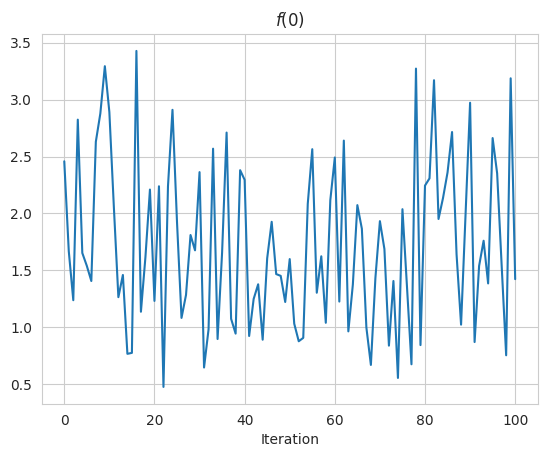

In [10]:
plt.plot(np.arange(big_steps), residual_history)
plt.xlabel("Iteration")
plt.title(r"$f(0)$")
# plt.title(r"$\frac{real \  feedback - predicted \ feedback} {num \ of \ predictions}$")
plt.show()